## Day and Night Image Classifier
---

The day/night image dataset consists of 200 RGB color images in two categories: day and night. There are equal numbers of each example: 100 day images and 100 night images.

We'd like to build a classifier that can accurately label these images as day or night, and that relies on finding distinguishing features between the two types of images!

*Note: All images come from the [AMOS dataset](http://cs.uky.edu/~jacobs/datasets/amos/) (Archive of Many Outdoor Scenes).*


#### Import resources

Before you get started on the project code, import the libraries and resources that you'll need.

In [1]:
import cv2 # computer vision library

import os
import glob # library for loading images from a directory

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

#### Training and Testing Data
The 200 day/night images are separated into training and testing datasets. 

* 60% of these images are training images, for you to use as you create a classifier.
* 40% are test images, which will be used to test the accuracy of your classifier.

In [2]:
# Image data directories
image_dir_training = "day_night_images/training/"
image_dir_test = "day_night_images/test/"

#### Load the datasets
Below function loads in images and their labels and places them in a list.
The list contains all images and their associated labels. 

In [3]:

def load_dataset(image_dir):
    
    # Populate this empty image list
    im_list = []
    image_types = ["day", "night"]
    
    # Iterate through each color folder
    for im_type in image_types:
        
        # Iterate through each image file in each image_type folder
        # glob reads in any image with the extension "image_dir/im_type/*"
        for file in glob.glob(os.path.join(image_dir, im_type, "*")):
            
            # Read in the image
            im = mpimg.imread(file)
            
            # Check if the image exists/if it's been correctly read-in
            if not im is None:
                # Append the image, and it's type (red, green, yellow) to the image list
                im_list.append((im, im_type))

    return im_list



The below line of code will load the training day/night images and store all of them in a variable, `IMAGE_LIST`. This list contains the images and their associated label ("day" or "night"). 

For example, the first image-label pair in `IMAGE_LIST` can be accessed by index: 
``` IMAGE_LIST[0][:]```.


In [4]:
# Load training data
IMAGE_LIST = load_dataset(image_dir_training)

## 1. Visualize the input images

---


Visualizing the image data is the first step in identifying any patterns in image data and being able to make predictions about the data!

Image shape: (471, 640, 3)
Image label: night
Pixel mean: 82.9986487084


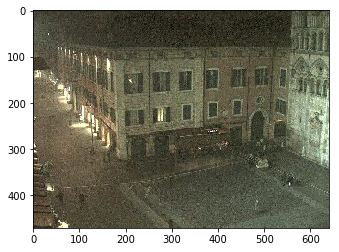

In [5]:
## Select an image and its label by list index
image_index = 160
selected_image = IMAGE_LIST[image_index][0]
selected_label = IMAGE_LIST[image_index][1]

## The shape of the image 
print('Image shape:', selected_image.shape)
## The image's label `selected_label`
print('Image label:', selected_label)

# Note the differences between the day and night images
# Any measurable differences can be used to classify these images
print('Pixel mean:', selected_image.mean())

plt.imshow(selected_image)

## 2. Pre-process the Data
---

It's important to make all your images the same size so that they can be sent through the same pipeline of classification steps! Every input image should be in the same format, of the same size, and so on.

#### Standardize the input images

* Resize each image to the desired input size: 600x1100px (hxw).

In [6]:
# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    
    ## Resize image so that all "standard" images are the same size 600x1100 (hxw) 
    return cv2.resize(image, (1100, 600))

(600, 1100, 3)


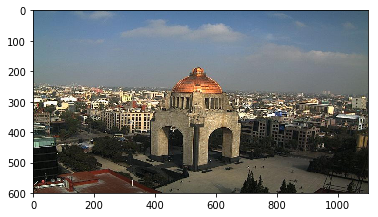

In [7]:
sample = standardize_input(IMAGE_LIST[0][0])
plt.imshow(sample)
print(sample.shape)

#### Standardize the output

With each loaded image, you also need to specify the expected output. 

It’s good practice to use numerical labels instead of strings or categorical labels. They're easier to track and compare. So, for our day and night, binary class example, instead of "day" and "night" labels we’ll use the numerical labels: `0` for night and `1` for day.

In [8]:
def encode(label):        
    ## Return a numerical label
    # 1 for "day" and 0 for "night"
    return 1 if label=="day" else 0

#### Construct a `STANDARDIZED_LIST` of input images and output labels.

This function takes in a list of image-label pairs and outputs a **standardized** list of resized images and numerical labels.

This uses the functions you defined above to standardize the input and output, so those functions must be complete for this standardization to work!


In [9]:
def standardize(image_list):
    
    # Empty image data array
    standard_list = []

    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # Create a numerical label
        binary_label = encode(label)    

        # Append the image, and it's one hot encoded label to the full, processed list of image data 
        standard_list.append((standardized_im, binary_label))
        
    return standard_list

# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

#### Visualize the standardized data

Display a standardized image from `STANDARDIZED_LIST`.

Shape: (600, 1100, 3)
Label: 1 [1 = day, 0 = night]


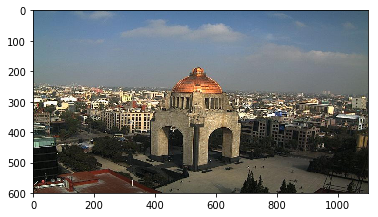

In [10]:
# Display a standardized image and its label

# Select an image by index
image_num = 0
selected_image = STANDARDIZED_LIST[image_num][0]
selected_label = STANDARDIZED_LIST[image_num][1]

# Display image and data about it
plt.imshow(selected_image)
print("Shape: "+str(selected_image.shape))
print(f"Label: {str(selected_label)} [1 = day, 0 = night]")



## 3. Feature Extraction       
---
Create a feature that represents the brightness in an image. We'll be extracting the **average brightness** using HSV colorspace. Specifically, we'll use the V channel (a measure of brightness), add up the pixel values in the V channel, then divide that sum by the area of the image to get the average Value of the image.


#### RGB to HSV conversion

Below, a test image is converted from RGB to HSV colorspace and each component is displayed in an image.

Label: 1


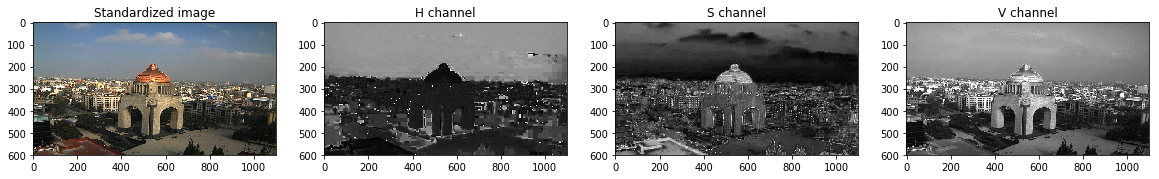

In [11]:
# Convert and image to HSV colorspace
# Visualize the individual color channels

image_num = 0
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]

# Convert to HSV
hsv = cv2.cvtColor(test_im, cv2.COLOR_RGB2HSV)

# Print image label
print('Label: ' + str(test_label))

# HSV channels
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]

# Plot the original image and the three channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.set_title('Standardized image')
ax1.imshow(test_im)
ax2.set_title('H channel')
ax2.imshow(h, cmap='gray')
ax3.set_title('S channel')
ax3.imshow(s, cmap='gray')
ax4.set_title('V channel')
ax4.imshow(v, cmap='gray')


---
####  Find the average brightness using the V channel

This function takes in a **standardized** RGB image and returns a feature (a single value) that represent the average level of brightness in the image. We'll use this value to classify the image as day or night.

In [12]:
# Find the average Value or brightness of an image
def avg_brightness(rgb_image):
    
    # Convert image to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    ## Calculate the average brightness 
    avg = np.mean(hsv[:, :, 2])
    
    return avg

Avg brightness: 95.9013166667


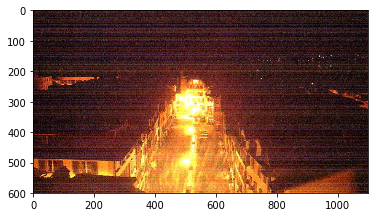

In [13]:
# Testing average brightness levels
# Look at a number of different day and night images and think about 
# what average brightness value separates the two types of images

# As an example, a "night" image is loaded in and its avg brightness is displayed
image_num = 190
test_im = STANDARDIZED_LIST[image_num][0]

avg = avg_brightness(test_im)
print('Avg brightness: ' + str(avg))
plt.imshow(test_im)

## 4. Classification and Visualizing Error
---
In this section, we'll turn our average brightness feature into a classifier that takes in a standardized image and returns a `predicted_label` for that image. This `estimate_label` function should return a value: 0 or 1 (night or day, respectively).

---
#### Build a complete classifier 

Set a threshold that will separate the day and night images by average brightness.

In [14]:
def estimate_label(rgb_image, threshold=103):
    # This function takes in RGB image input and returns predicted output
    # Default threshold set to 103 as calculated further to be the most efficient.
    avg = avg_brightness(rgb_image)
    
    # Return the predicted_label (0 or 1) based on whether the avg is 
    # above or below the threshold
    predicted_label = 1 if (avg > threshold) else 0
    
    return predicted_label    
    

#### Testing the classifier

Here is where we test your classification algorithm using our test set of data that we set aside at the beginning of the notebook!

Since we are using a pretty simple brightess feature, we may not expect this classifier to be 100% accurate. We'll aim for around 75-85% accuracy usin this one feature.

In [15]:
# test prediction function to evaluate accuracy 
predictions = [estimate_label(img[0]) for img  in STANDARDIZED_LIST]

In [16]:
import random

# Using the load_dataset function in helpers.py
# Load test data
TEST_IMAGE_LIST = load_dataset(image_dir_test)

# Standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

# find the image averate pixel threshold
for t in range(101, 106):
    predictions = [estimate_label(img[0], threshold=t) for img in STANDARDIZED_LIST]
    predictions_to_label = [prediction == label[1] for prediction, label in zip(predictions, STANDARDIZED_LIST)]
    print(f'Threshold: {t} -> accuracy:',
          sum(predictions_to_label)/len(predictions_to_label))

Threshold: 101 -> accuracy: 0.9041666666666667
Threshold: 102 -> accuracy: 0.9083333333333333
Threshold: 103 -> accuracy: 0.9125
Threshold: 104 -> accuracy: 0.9083333333333333
Threshold: 105 -> accuracy: 0.8916666666666667


## 5. Determine the Accuracy

Compare the output of your classification algorithm (a.k.a. your "model") with the true labels and determine the accuracy.

This code stores all the misclassified images, their predicted labels, and their true labels, in a list called `misclassified`.

In [17]:
# Constructs a list of misclassified images given a list of test images and their labels
def get_misclassified_images(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []

    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:

        # Get true data
        im = image[0]
        true_label = image[1]

        # Get predicted label from your classifier
        predicted_label = estimate_label(im)

        # Compare true and predicted labels 
        if(predicted_label != true_label):
            # If these labels are not equal, the image has been misclassified
            misclassified_images_labels.append((im, predicted_label, true_label))
            
    # Return the list of misclassified [image, predicted_label, true_label] values
    return misclassified_images_labels


In [18]:
# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) +' out of '+ str(total))

Accuracy: 0.925
Number of misclassified images = 12 out of 160


---
#### Visualize the misclassified images

Visualize some of the images you classified wrong (in the `MISCLASSIFIED` list) and note any qualities that make them difficult to classify. This will help you identify any weaknesses in your classification algorithm.

Image predicted as 0,
where: 0 is night and 1 is day


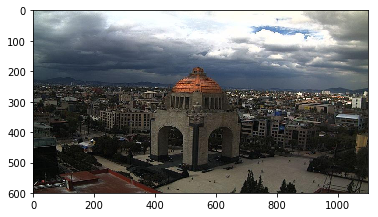

--------------------------------------------------
Image predicted as 1,
where: 0 is night and 1 is day


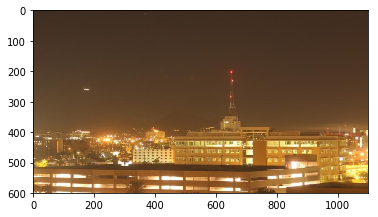

--------------------------------------------------
Image predicted as 0,
where: 0 is night and 1 is day


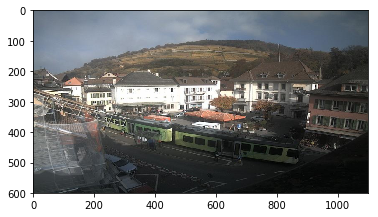

--------------------------------------------------
Image predicted as 1,
where: 0 is night and 1 is day


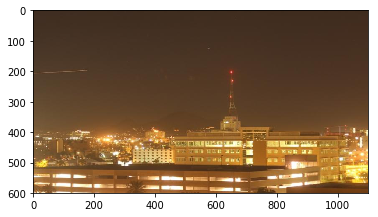

--------------------------------------------------
Image predicted as 1,
where: 0 is night and 1 is day


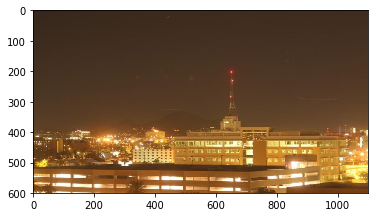

--------------------------------------------------
Image predicted as 1,
where: 0 is night and 1 is day


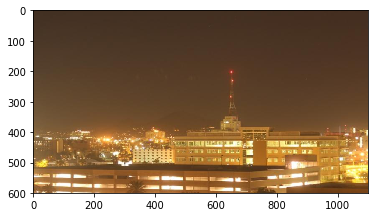

--------------------------------------------------
Image predicted as 1,
where: 0 is night and 1 is day


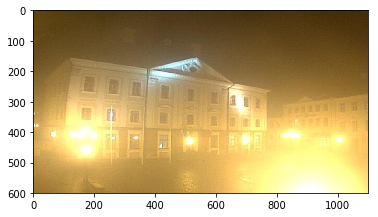

--------------------------------------------------
Image predicted as 0,
where: 0 is night and 1 is day


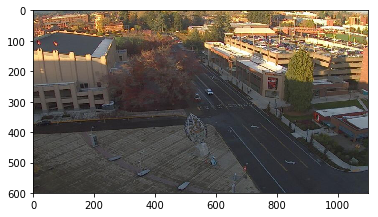

--------------------------------------------------
Image predicted as 1,
where: 0 is night and 1 is day


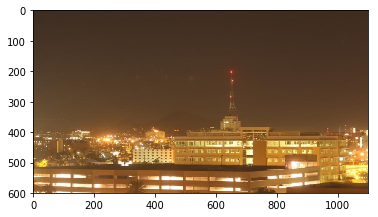

--------------------------------------------------
Image predicted as 1,
where: 0 is night and 1 is day


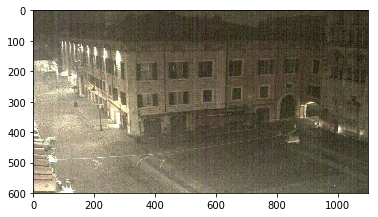

--------------------------------------------------
Image predicted as 0,
where: 0 is night and 1 is day


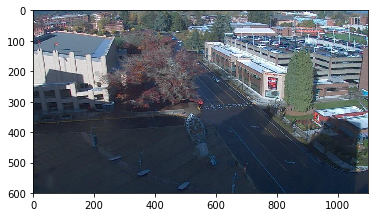

--------------------------------------------------
Image predicted as 1,
where: 0 is night and 1 is day


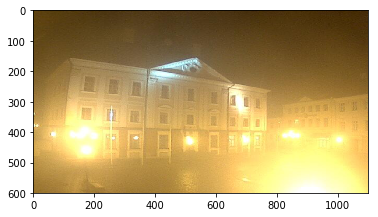

--------------------------------------------------


In [19]:
# Visualize misclassified example(s)
num = 5
test_mis_im = MISCLASSIFIED[num][0]

## Display an image in the `MISCLASSIFIED` list 
for i in range(len(MISCLASSIFIED)):
    plt.imshow(MISCLASSIFIED[i][0])
    print(f"Image predicted as {MISCLASSIFIED[i][1]},\nwhere: 0 is night and 1 is day", )
    plt.show()
    print('-'*50)
## Print out its predicted label - 
## to see what the image *was* incorrectly classified as


---
## (Question): After visualizing these misclassifications, what weaknesses do you think your classification algorithm has?
**Answer:** 

The classifier predicts data based on the average pixel value and doesn't consider any other features: 
1. Night images with high presence of very bright street light tend to be misclassified as day
2. Day images with significant amount of shaddow or dark cloudy day tend to be misclassified as night 